# A. Conditional density estimation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import torch
import numpy as np
import pandas as pd
from torch import nn

from matplotlib import cm
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

cwd = os.getcwd()
h, _ = os.path.split(cwd)

sys.path.append(h)

from scripts import viz, metrics

In [3]:
from datetime import datetime

MODEL_NAME = "cvae"
DATE = datetime.today().strftime('%d.%m_%H.%M')
RESULTS_FOLDER = f"{MODEL_NAME}/{DATE}"
print(RESULTS_FOLDER)


sample_dir = os.path.join(os.getcwd(), f'{RESULTS_FOLDER}/samples')
config_dir = os.path.join(os.getcwd(), f'{RESULTS_FOLDER}/configs')
metrics_dir = os.path.join(os.getcwd(), f'{RESULTS_FOLDER}/metrics')
classifier_dir = os.path.join(os.getcwd(), f'{RESULTS_FOLDER}/classifiers')
checkpoint_dir = os.path.join(os.getcwd(), f'{RESULTS_FOLDER}/checkpoints')

for fld in [sample_dir, config_dir, metrics_dir, classifier_dir, checkpoint_dir]:
    os.makedirs(fld, exist_ok=True)

cvae/06.06_14.36


## Data

In [4]:
sb_train = pd.read_csv("../data/mock/SB_train.csv")
sb_train = shuffle(sb_train, random_state=42)

sb_valid = pd.read_csv("../data/mock/SB_val.csv")
sb_valid = shuffle(sb_valid, random_state=42)

sb_train.shape, sb_valid.shape

((500000, 6), (378876, 6))

In [5]:
X_train = sb_train[['1', '2', '3', '4']].values
C_train = sb_train[['0']].values

X_valid = sb_valid[['1', '2', '3', '4']].values
C_valid = sb_valid[['0']].values

## Fit CVAE

In [6]:
from models import CVAE

cvae_args_dict = {
    'var_dim': 4,
    'cond_dim': 1,
    'latent_dim': 8,
    'hid_shapes': (512, 256, 128, 64, 32, 16),
    'act': nn.Tanh(),
    'KL_weight': 1e-3,
    'n_epochs': 100,
    'batch_size': 256,
    'checkpoint_dir': checkpoint_dir,
    'device': 'cuda',
}

wrapper = CVAE(**cvae_args_dict)
wrapper.clear_checkpoints()
wrapper.param_summary()

Directory C:\Users\Oleg\Github\my_new_physics\notebooks\cvae/06.06_14.36/checkpoints already exists or can not be created
Directory C:\Users\Oleg\Github\my_new_physics\notebooks\cvae/06.06_14.36/checkpoints has been cleared!
Layer (type:depth-idx)                   Param #
CondVAE                                  --
├─Tanh: 1-1                              --
├─Encoder: 1-2                           --
│    └─Sequential: 2-1                   --
│    │    └─Linear: 3-1                  3,072
│    │    └─Tanh: 3-2                    --
│    │    └─Linear: 3-3                  131,328
│    │    └─Tanh: 3-4                    --
│    │    └─Linear: 3-5                  32,896
│    │    └─Tanh: 3-6                    --
│    │    └─Linear: 3-7                  8,256
│    │    └─Tanh: 3-8                    --
│    │    └─Linear: 3-9                  2,080
│    │    └─Tanh: 3-10                   --
│    │    └─Linear: 3-11                 528
│    │    └─Tanh: 3-12                   --
│  

In [7]:
from torch.optim.lr_scheduler import ExponentialLR

start_lr = 1e-4
weight_decay = 1e-6
n_epochs = cvae_args_dict['n_epochs']

wrapper.set_optimizer(lr=start_lr, weight_decay=weight_decay)

In [8]:
import json

full_config = {
    "cvae": cvae_args_dict,
    "train_args": {
        "start_lr": start_lr, 
        "weight_decay": weight_decay,
        "n_epochs": n_epochs,
    }
}

full_config["cvae"]["act"] = str(cvae_args_dict["act"])

with open(os.path.join(config_dir, "config.json"), "w") as outfile: 
    json.dump(full_config, outfile, indent=4)

In [9]:
from scripts.data_scaling import CATHODEScaler

gen_model_scaler = CATHODEScaler().fit(X_train, C_train)
X_train_scaled, C_train_scaled = gen_model_scaler.transform(X_train, C_train)
X_valid_scaled, C_valid_scaled = gen_model_scaler.transform(X_valid, C_valid)
X_train_scaled.shape, C_train_scaled.shape, X_valid_scaled.shape, C_valid_scaled.shape

((499927, 4), (499927, 1), (378832, 4), (378832, 1))

In [10]:
wrapper = wrapper.fit(X_train_scaled, C_train_scaled, X_valid_scaled, C_valid_scaled)

Epoch: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [58:04<00:00, 34.84s/it]

C:\Users\Oleg\Github\my_new_physics\notebooks\cvae/06.06_14.36/checkpoints\best


Best train loss: 0.01430
Last valid loss: 0.01439 on epoch: [92]


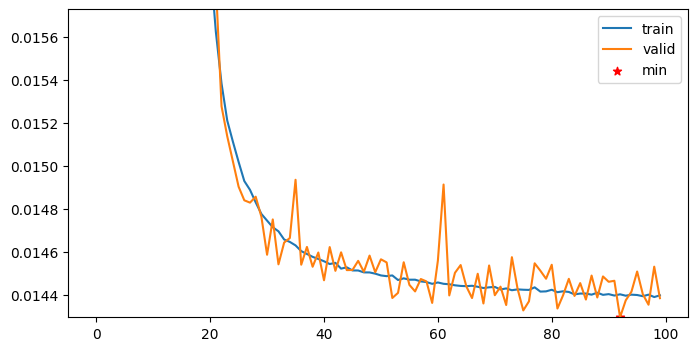

In [11]:
valid_losses = wrapper.valid_losses
min_loss = np.min(valid_losses)
last_loss = valid_losses[-1]
min_epoch = np.argmin(valid_losses).flatten()
min_loss = np.min(wrapper.valid_losses)

print(f"Best train loss: {min_loss:.5f}")
print(f"Last valid loss: {last_loss:.5f} on epoch: {min_epoch}")
plt.figure(figsize=(8, 4))
plt.plot(wrapper.train_losses, label="train")
plt.plot(valid_losses, label="valid")
plt.scatter(min_epoch, min_loss, c="r", label="min", marker="*")
plt.ylim([min_loss, min_loss * 1.1])
plt.legend()
plt.show()

In [12]:
last = len(valid_losses)
wrapper.load_from_checkpoint(last)

C:\Users\Oleg\Github\my_new_physics\notebooks\cvae/06.06_14.36/checkpoints\100


## Quality metrics on validation sample

In [13]:
# sample new objects
X_gen_valid_logit = wrapper.sample(C_valid, batch_size=15000)
X_gen_valid = gen_model_scaler.inverse_transform(X_gen_valid_logit)
np.save(os.path.join(sample_dir, "density_estimation.npy"), X_gen_valid)

batch: 100%|███████████████████████████████████████████████████████████████████████████| 26/26 [00:02<00:00, 10.44it/s]


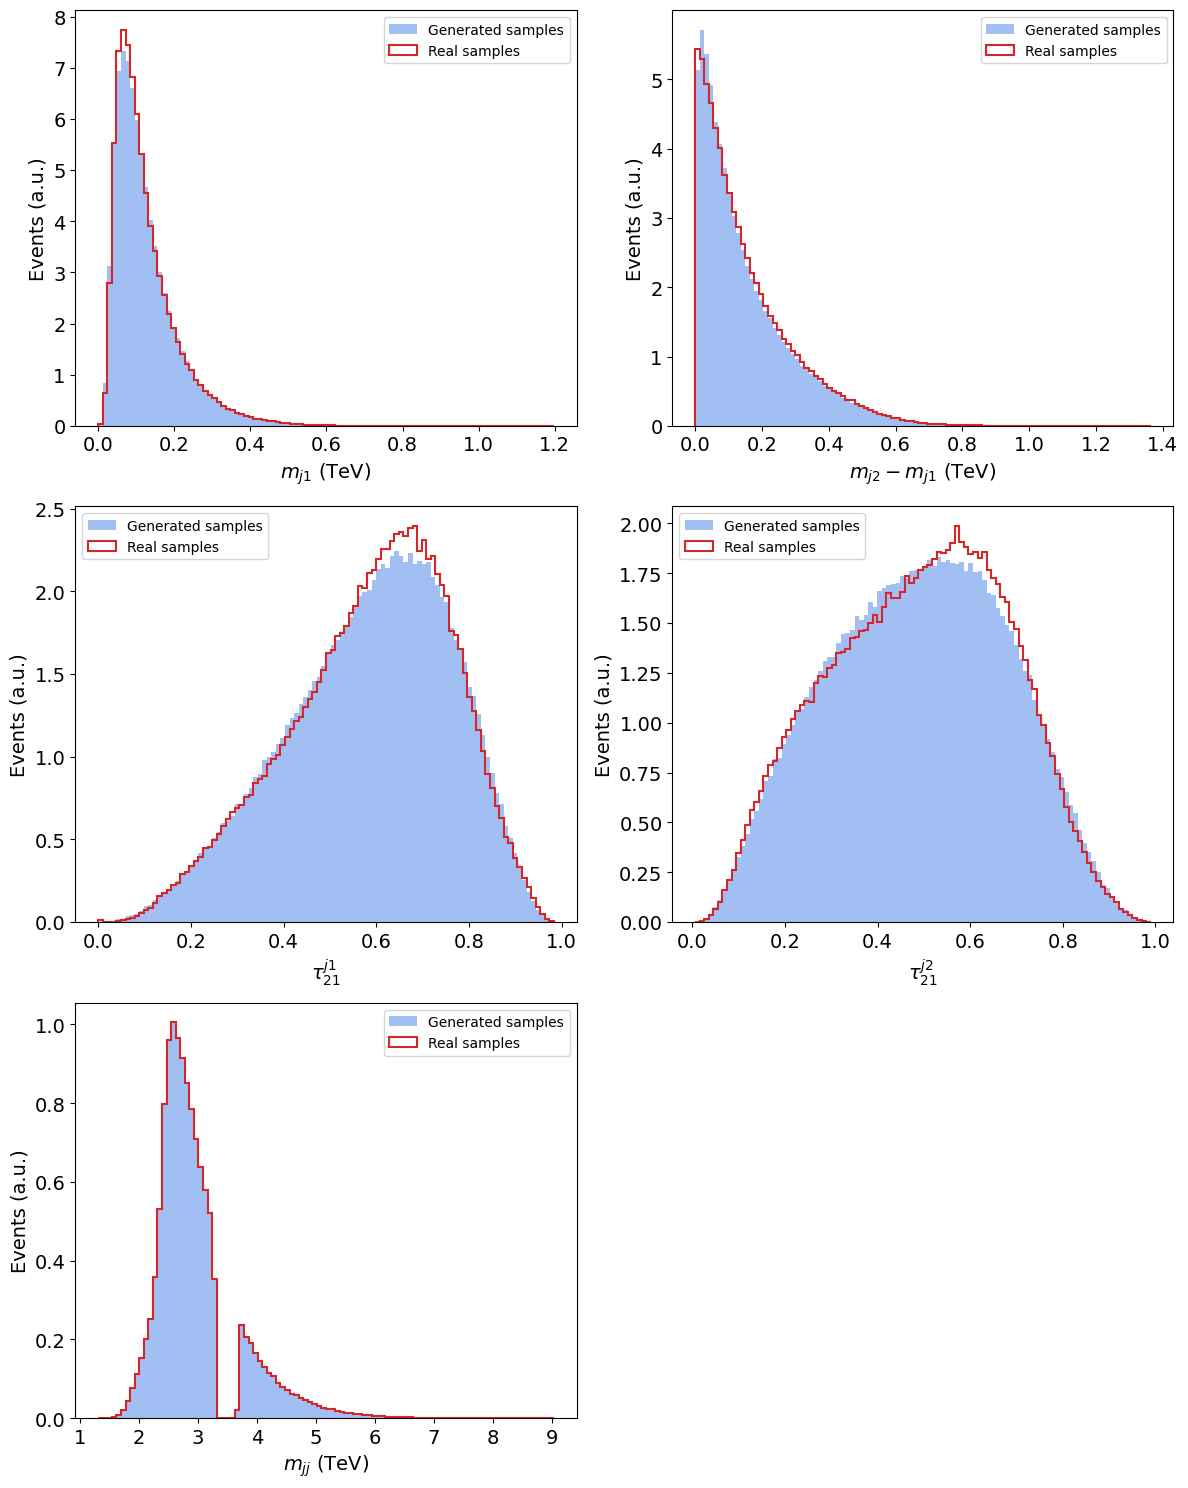

In [14]:
viz.plot_histograms(X_valid, C_valid, X_gen_valid, C_valid)

In [15]:
%%time
metrics.get_metrics(X_valid, C_valid, X_gen_valid, C_valid)

Frechet Distance         = 0.003102 +- 0.000292
Kolmogorov-Smirnov       = 0.010363 +- 0.000427
Cramer-von Mises         = 8.151464 +- 0.720173
Anderson-Darling         = 61.082856 +- 3.986519
Kullback-Leibler KDE     = 0.000361 +- 0.000014
Jensen-Shannon KDE       = 0.000092 +- 0.000005
CPU times: total: 15min 54s
Wall time: 15min 57s


**Best:**

```
Frechet Distance         = 0.000535 +- 0.000118
Kolmogorov-Smirnov       = 0.003703 +- 0.000343
Cramer-von Mises         = 0.695247 +- 0.182382
Anderson-Darling         = 5.139838 +- 1.373714
Kullback-Leibler KDE     = 0.000062 +- 0.000010
Jensen-Shannon KDE       = 0.000015 +- 0.000002
```

#  B. Interpolation and sampling

## Data

In [16]:
sr_train = pd.read_csv("../data/mock/SR_train.csv")
sr_train = shuffle(sr_train, random_state=42)

sr_valid = pd.read_csv("../data/mock/SR_val.csv")
sr_valid = shuffle(sr_valid, random_state=42)

sr_train.shape, sr_valid.shape

((60000, 6), (60000, 6))

In [17]:
# select only background events
sr_train_bkg = sr_train[sr_train['5'] == 0]
sr_valid_bkg = sr_valid[sr_valid['5'] == 0]

sr_train_bkg.shape, sr_valid_bkg.shape

((59605, 6), (59631, 6))

In [18]:
X_sr_train = sr_train[['1', '2', '3', '4']].values
C_sr_train = sr_train[['0']].values
X_sr_train_bkg = sr_train_bkg[['1', '2', '3', '4']].values
C_sr_train_bkg = sr_train_bkg[['0']].values

X_sr_valid = sr_valid[['1', '2', '3', '4']].values
C_sr_valid = sr_valid[['0']].values
X_sr_valid_bkg = sr_valid_bkg[['1', '2', '3', '4']].values
C_sr_valid_bkg = sr_valid_bkg[['0']].values

## Condition sampling with KDE

In [19]:
from sklearn.neighbors import KernelDensity

# Стандартизация не используется
# https://github.com/HEPML-AnomalyDetection/CATHODE/blob/main/data_handler.py#L683
ls_sr_cond = CATHODEScaler(use_standard=False).fit(C_sr_train)
C_sr_train_logit = ls_sr_cond.transform(C_sr_train)

kd = KernelDensity(bandwidth=0.01, kernel='gaussian').fit(C_sr_train_logit)

# N models
N = 10
cond_len = len(C_sr_valid_bkg)
# Генерируем для метрик
C_gen_sr_valid_bkg = ls_sr_cond.inverse_transform(kd.sample(cond_len))[:-(cond_len % N)]  # Чтобы было кратно
# Генерируем для семплинга X
C_sr_valid_bkg_sliced_N = C_sr_valid_bkg[:-(cond_len % N)]  # Чтобы было кратно
C_gen_sr_valid_bkg_N = ls_sr_cond.inverse_transform(kd.sample(len(C_sr_valid_bkg_sliced_N) // N))

## Background interpolation in the signal region

In [20]:
# N models
X_gen_sr_valid_bkg_N_logit = wrapper.sample_from_N_checkpoints(C_gen_sr_valid_bkg_N, N=N, batch_size=15000)
X_gen_sr_valid_bkg_N = gen_model_scaler.inverse_transform(X_gen_sr_valid_bkg_N_logit)
np.save(os.path.join(sample_dir, "interpolation.npy"), X_gen_sr_valid_bkg_N)

C:\Users\Oleg\Github\my_new_physics\notebooks\cvae/06.06_14.36/checkpoints\93


batch: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.64it/s]


C:\Users\Oleg\Github\my_new_physics\notebooks\cvae/06.06_14.36/checkpoints\76


batch: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.46it/s]


C:\Users\Oleg\Github\my_new_physics\notebooks\cvae/06.06_14.36/checkpoints\82


batch: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.19it/s]


C:\Users\Oleg\Github\my_new_physics\notebooks\cvae/06.06_14.36/checkpoints\73


batch: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.98it/s]


C:\Users\Oleg\Github\my_new_physics\notebooks\cvae/06.06_14.36/checkpoints\98


batch: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.56it/s]


C:\Users\Oleg\Github\my_new_physics\notebooks\cvae/06.06_14.36/checkpoints\69


batch: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.89it/s]


C:\Users\Oleg\Github\my_new_physics\notebooks\cvae/06.06_14.36/checkpoints\60


batch: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.70it/s]


C:\Users\Oleg\Github\my_new_physics\notebooks\cvae/06.06_14.36/checkpoints\77


batch: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.94it/s]


C:\Users\Oleg\Github\my_new_physics\notebooks\cvae/06.06_14.36/checkpoints\94


batch: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.30it/s]


C:\Users\Oleg\Github\my_new_physics\notebooks\cvae/06.06_14.36/checkpoints\87


batch: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.70it/s]


## Quality of background sampling

**Single model**

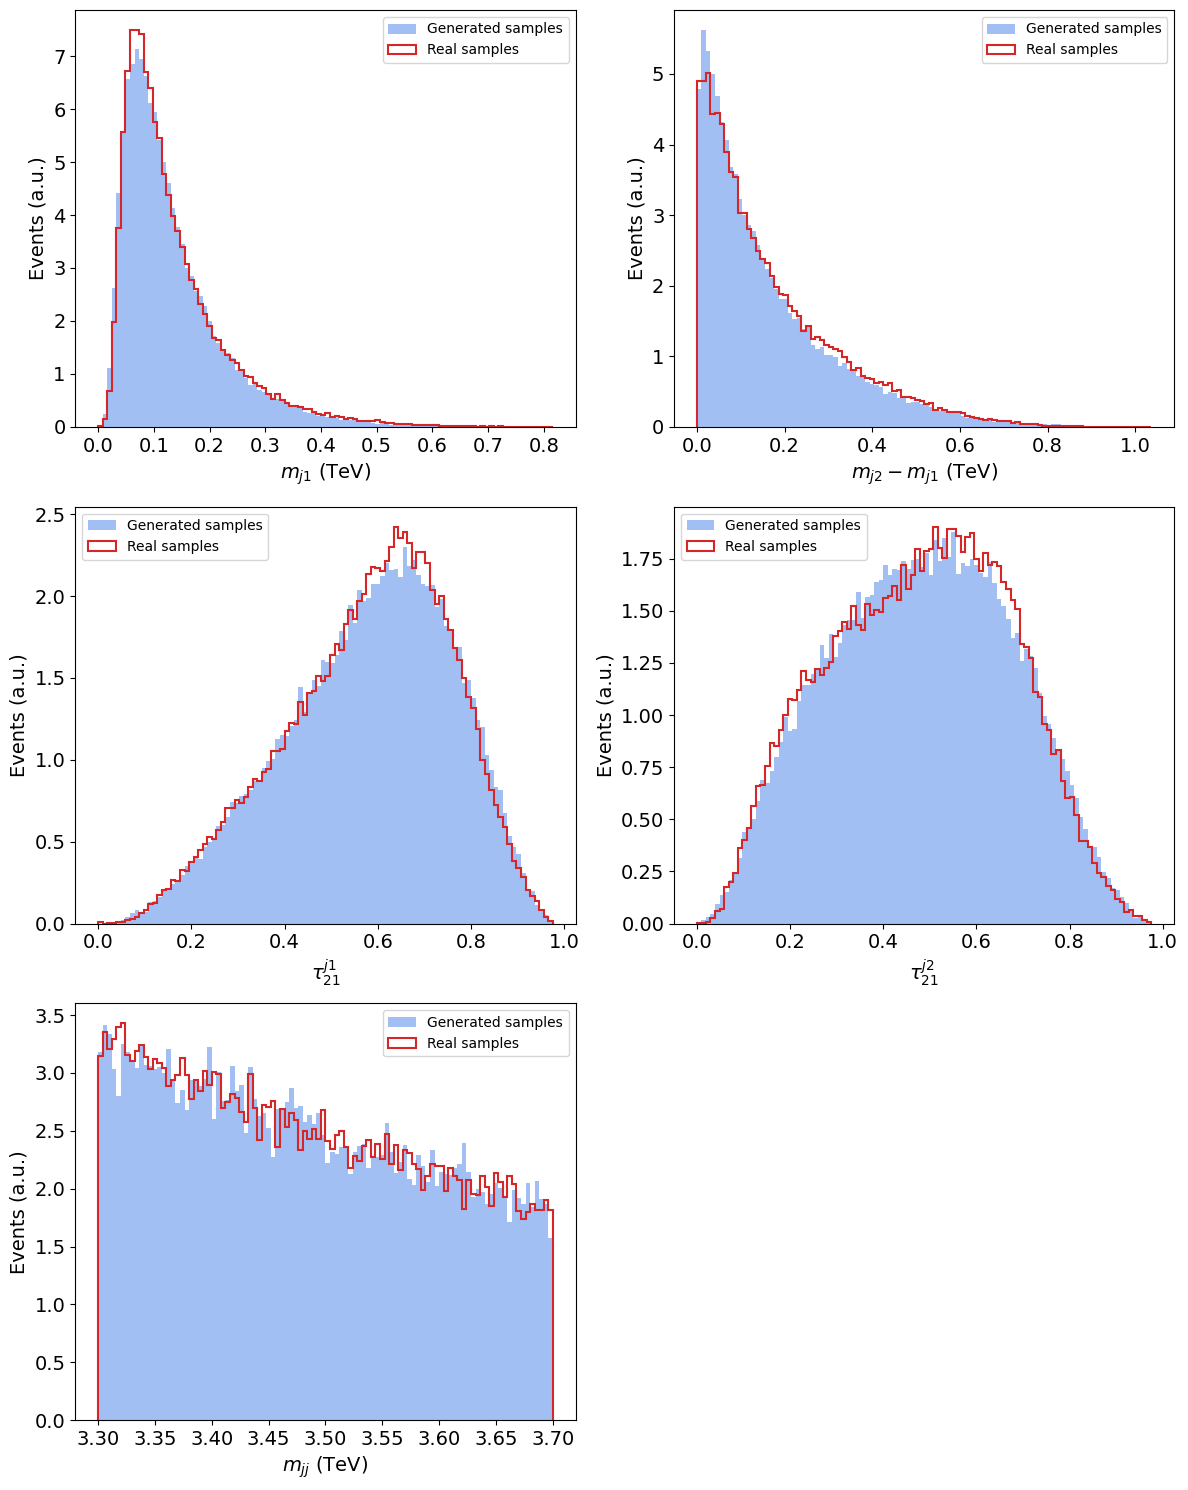

In [21]:
viz.plot_histograms(X_sr_valid_bkg, C_sr_valid_bkg, X_gen_sr_valid_bkg_N, C_gen_sr_valid_bkg)

In [22]:
%%time
metrics.get_metrics(X_sr_valid_bkg, C_sr_valid_bkg, X_gen_sr_valid_bkg_N, C_gen_sr_valid_bkg)

Frechet Distance         = 0.006638 +- 0.000902
Kolmogorov-Smirnov       = 0.016016 +- 0.000997
Cramer-von Mises         = 2.864142 +- 0.418794
Anderson-Darling         = 22.715475 +- 2.652850
Kullback-Leibler KDE     = 0.000477 +- 0.000032
Jensen-Shannon KDE       = 0.000121 +- 0.000016
CPU times: total: 2min 6s
Wall time: 2min 6s


**Best:**

```
Frechet Distance         = 0.002222 +- 0.000467
Kolmogorov-Smirnov       = 0.008405 +- 0.000877
Cramer-von Mises         = 0.544708 +- 0.169356
Anderson-Darling         = 3.407478 +- 1.219137
Kullback-Leibler KDE     = 0.000106 +- 0.000024
Jensen-Shannon KDE       = 0.000022 +- 0.000005
```

# C. Classification

## Собираем данные для классификации

Берем по 60К данных из mock и генерим 200К данных на обучение и валидацию, все в SR. Перед подачей в классификатор -- только стандартизация (логит не используется). Классы взвешиваются с учетом дисбаланса при подсчете лосса.

In [23]:
C_sr_train.min(), C_sr_train.max()

(3.3000058388954225, 3.6999854616441583)

**Генерим условие (массу)**

In [24]:
N_samples = 40000

C_sr_train_logit = ls_sr_cond.transform(C_sr_train)

kd = KernelDensity(bandwidth=0.01, kernel='gaussian').fit(C_sr_train_logit)
C_gen_sr_bkg = ls_sr_cond.inverse_transform(kd.sample(N_samples, random_state=42))
C_gen_sr_bkg.min(), C_gen_sr_bkg.max()

(3.300017618131705, 3.6999720208651743)

**Генерим данные**

In [25]:
len(C_gen_sr_bkg)

40000

In [26]:
N_models = 10

torch.cuda.empty_cache()
X_gen_sr_bkg_logit = wrapper.sample_from_N_checkpoints(C_gen_sr_bkg, N=N_models, batch_size=25000)
X_gen_sr_bkg = gen_model_scaler.inverse_transform(X_gen_sr_bkg_logit)

assert len(X_gen_sr_bkg) == N_models * N_samples
np.save(os.path.join(sample_dir, "cls_sampled_X.npy"), X_gen_sr_bkg)

C:\Users\Oleg\Github\my_new_physics\notebooks\cvae/06.06_14.36/checkpoints\93


batch: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.90it/s]


C:\Users\Oleg\Github\my_new_physics\notebooks\cvae/06.06_14.36/checkpoints\76


batch: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.74it/s]


C:\Users\Oleg\Github\my_new_physics\notebooks\cvae/06.06_14.36/checkpoints\82


batch: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


C:\Users\Oleg\Github\my_new_physics\notebooks\cvae/06.06_14.36/checkpoints\73


batch: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.11it/s]


C:\Users\Oleg\Github\my_new_physics\notebooks\cvae/06.06_14.36/checkpoints\98


batch: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.92it/s]


C:\Users\Oleg\Github\my_new_physics\notebooks\cvae/06.06_14.36/checkpoints\69


batch: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.70it/s]


C:\Users\Oleg\Github\my_new_physics\notebooks\cvae/06.06_14.36/checkpoints\60


batch: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.21it/s]


C:\Users\Oleg\Github\my_new_physics\notebooks\cvae/06.06_14.36/checkpoints\77


batch: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.45it/s]


C:\Users\Oleg\Github\my_new_physics\notebooks\cvae/06.06_14.36/checkpoints\94


batch: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.41it/s]


C:\Users\Oleg\Github\my_new_physics\notebooks\cvae/06.06_14.36/checkpoints\87


batch: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.06it/s]


In [27]:
C_gen_sr_bkg = ls_sr_cond.inverse_transform(kd.sample(N_models * N_samples, random_state=42))
np.save(os.path.join(sample_dir, "cls_sampled_mjj.npy"), C_gen_sr_bkg)

**Присваиваем классы, создаем обучающий и валидационный наборы**

In [28]:
# mock
train_mock = sr_train.to_numpy()
valid_mock = sr_valid.to_numpy()

train_mock = np.hstack([train_mock, np.ones((train_mock.shape[0], 1))])
valid_mock = np.hstack([valid_mock, np.ones((valid_mock.shape[0], 1))])
train_mock.shape, valid_mock.shape

((60000, 7), (60000, 7))

In [29]:
X_gen_sr_bkg = np.hstack([C_gen_sr_bkg, X_gen_sr_bkg, np.zeros((N_models * N_samples, 1)), np.zeros((N_models * N_samples, 1))])
X_gen_sr_bkg.shape

(400000, 7)

**Делим синтетические данные на обучение и валидацию**

In [30]:
from sklearn.model_selection import train_test_split

train_gen, valid_gen = train_test_split(X_gen_sr_bkg, test_size=0.5, random_state=42, shuffle=True)
train_gen.shape, valid_gen.shape

((200000, 7), (200000, 7))

**Мешаем все вместе с реальными данными**

In [31]:
X_train = shuffle(np.vstack([train_gen, train_mock]), random_state=42)
X_valid = shuffle(np.vstack([valid_gen, valid_mock]), random_state=42)
X_train.shape, X_valid.shape

((260000, 7), (260000, 7))

In [32]:
m_train = X_train[:, 0]
m_valid = X_valid[:, 0]

is_sig_train = X_train[:, -2]
is_sig_valid = X_valid[:, -2]

is_real_train = X_train[:, -1]
is_real_valid = X_valid[:, -1]

data_train = X_train[:, 1:-2]
data_valid = X_valid[:, 1:-2]

## Обучение

In [33]:
BATCH_SIZE = 128
N_EPOCHS = 100
N_RUNS = 3

In [34]:
from scripts.nn_classifier import get_loaders

loaders, class_weight = get_loaders(data_train, is_real_train, data_valid, is_real_valid, batch_size=BATCH_SIZE)

class_weight: [0.65       2.16666667]


In [35]:
from scripts.nn_classifier import train_classifier

model_paths = train_classifier(loaders, class_weight, classifier_dir, n_epochs=N_EPOCHS, n_runs=N_RUNS)

Run 1...


epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Run 2...


epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Run 3...


epoch:   0%|          | 0/100 [00:00<?, ?it/s]

10
Run 1 minimum validation loss epochs: [52 44 28 27 19 34 30 21 50 18]
Run 2 minimum validation loss epochs: [47 38 33 23 13 37 29 10 20 28]
Run 3 minimum validation loss epochs: [49 14 29 30 38 31 37 42 39 50]


## Предикты на тесте

In [36]:
sr_test = pd.read_csv("../data/evaluation/SR_test.csv").to_numpy()
extrabg_sr_test = pd.read_csv("../data/evaluation/extrabg_SR_test.csv").to_numpy()
X_test = np.vstack([sr_test, extrabg_sr_test])
is_sig_test = X_test[:, -1].astype(int)

# X_test_wo_mjj = X_test[:, 1:-1]
# X_test_w_mjj = X_test[:, 0:-1]

X_test.shape

(360000, 6)

In [37]:
from sklearn.preprocessing import StandardScaler
from scripts.nn_classifier import preds_from_model

sc = StandardScaler().fit(data_train)
preds_matrix = preds_from_model(X_test, sc, model_paths, save_dir=classifier_dir)
np.save(os.path.join(sample_dir, "preds_matrix.npy"), preds_matrix)
preds_matrix.shape

(3, 1, 360000)

# D. Anomaly Detection

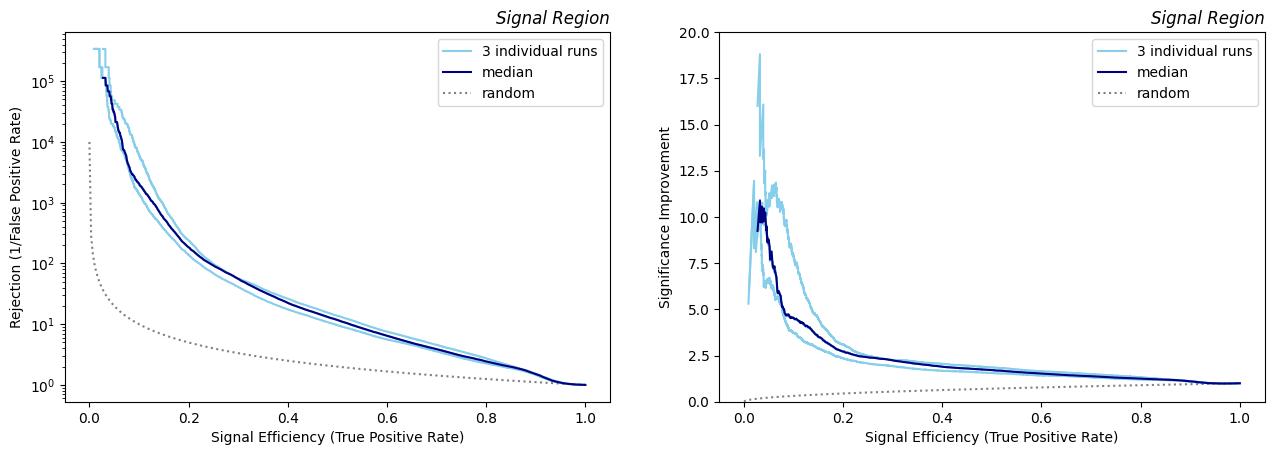

,AUC-ROC,AUC-PR,AUC-SIC
run 1,0.771029,0.344151,2.123772
run 2,0.784842,0.382990,2.591942
run 3,0.797604,0.387147,2.315596


In [38]:
from scripts.metrics import DetectionMetrics

det_metrics = DetectionMetrics()
det_metrics.show(preds_matrix, is_sig_test, save_dir=metrics_dir)